In [1]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.29 10:25:02      +
  ++++++++++++++++++++++++++++++++++++++++++++


## Plotting function

In [2]:
def plot_this_twiss(fig, twiss):
    ''' Created by Y. Dutheil'''
    plt.rcParams.update({'axes.labelsize': 16, 'axes.titlesize': 16})
    gs = mpl.gridspec.GridSpec(4, 1, height_ratios=[1, 4, 4, 2])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax4 = fig.add_subplot(gs[3], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s'], twiss['betx'], 'r-')
    ax2.plot(twiss['s'], twiss['bety'], 'b-')        

    #3rd plot is dispersion functions
    ax3.set_ylabel('D (m)')
    ax3.plot(twiss['s'], twiss['dx'], 'r-')
    ax3.plot(twiss['s'], twiss['dy'], 'b-')
    
    #4th plot is beam size
    ax4.set_ylabel('4$\sigma$ (mm)')
    ax4.set_xlabel('S (m)')
    
    pc = 3.5 # GeV/c
    m_e = 0.511e-3 # GeV
    betagamma = pc/m_e
    emit_n = 20e-6 # m
    emit = emit_n / betagamma
    dpp = 1e-3
    
    twiss_sigx = 4* np.sqrt(emit * twiss['betx'] + twiss['dx']**2 * dpp**2 ) * 1E3
    twiss_sigy = 4* np.sqrt(emit * twiss['bety'] + twiss['dy']**2 * dpp**2 ) * 1E3
    ax4.plot(twiss['s'], twiss_sigx, 'r-')
    ax4.plot(twiss['s'], twiss_sigy, 'b-')    
    
    ax4.fill_between(twiss['s'], twiss_sigx, color='r', alpha=0.2)
    ax4.fill_between(twiss['s'], twiss_sigy, color='b', alpha=0.2)

    axnames = ax1.twiny()
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)
    ax1._shared_x_axes.join(ax1, axnames)

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s'])
        ticks_labels += list(sub_twiss.index)

    axnames.set_xticks(ticks)
    axnames.set_xticklabels(ticks_labels, rotation=90)

    ax3.set_xlabel('s (m)')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())
    plt.show()

## Extracting TT61 from SPS and reversing

Accelerating structures from [CERN Accelerator Models](https://gitlab.cern.ch/acc-models/acc-models-tls)

In [3]:
#Locating files from repositry
sps_extr_repo = 'acc-models-tls/sps_extraction/sps_ext_elements'
ti2_repo = 'acc-models-tls/sps_extraction/tt60ti2'
ti2_line_repo = 'acc-models-tls/sps_extraction/tt60ti2_q26/line'
tt60ti2_q26 = 'acc-models-tls/sps_extraction/tt60ti2_q26/stitched'
sps_repo = 'acc-models-sps'

#Apertures of the SPS - from Y. Dutheil
madx.call('aperturedb_1.dbx')
madx.call('aperturedb_2.dbx')
madx.call('aperturedb_3.dbx')

#TT60 line
madx.call(ti2_repo+'/ti2.seq')
madx.call(ti2_repo+'/ti2_apertures.dbx')
madx.call(ti2_line_repo+'/ti2_q26.str')

#Beam is defined with a proton beam
madx.input('''
beam,    sequence=ti2, particle=proton, pc= 450;
use,     sequence=ti2;
ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;
''')
madx.call(ti2_repo+'/mbi_b3_error.madx')

madx.use('ti2')
# loading initial twiss parameters and transporting them along the ti2
madx.call(tt60ti2_q26+'/sps_tt60_ti2_lhc_q26.inp')
twiss_ti2 = madx.twiss(betx=madx.globals['betx0'], alfx=madx.globals['alfx0'], bety=madx.globals['bety0'], alfy=madx.globals['alfy0'], dx=madx.globals['dx0'], dpx=madx.globals['dpx0']).dframe()

#saving the length of that sequence
madx.globals['ti2_length'] = madx.table['summ'].length[0]

#Finding SPS sequence
madx.call(sps_repo+'/sps.seq')
madx.call(sps_repo+'/strengths/lhc_q26.str')
madx.call(sps_extr_repo+'/fast_extraction_macros.cmdx')

madx.input('''
Beam, particle=PROTON,pc=450,exn=3.5e-6,eyn=3.5E-6;
BRHO      := BEAM->PC * 3.3356;
ex_g = beam->ex;
ey_g = beam->ey;
dpp = 1.5e-3;

use, sequence=SPS;
exec, install_extraction_points();
! Cycle machine to end at extraction point in LSS6
SEQEDIT, sequence=SPS;
CYCLE, START=EXTRPT_6_start;
FLATTEN;
ENDEDIT;

use, sequence = sps;

savebeta, label=extracting, place = EXTRPT_6_START;
twiss;
exec, replace_quad(qda.61910, qda.619.coil);
qda.619.coil, k1 :=  -0.16 * kqda;
''')
madx.globals['sps_length'] = madx.table['summ'].length[0]

madx.input('''
sps_ti2: sequence, refer=entry, l= sps_length + ti2_length;
  sps, at=0;
  ti2, at=sps_length;
  endsequence;
''')

#Once the sequences have been called, the line can be used to find parameters, and then reversing the TT61 line

madx.use('sps_ti2')
twiss_sps_ti2 = madx.twiss(beta0='extracting').dframe()

twiss_forward_extrpt_6 = twiss_sps_ti2.loc['extrpt_6']
twiss_forward_end_share_ti2 = twiss_sps_ti2.loc['mciav.20304']

madx.command.seqedit(sequence='sps_ti2')
madx.command.flatten()
madx.command.install(element='END_SHARE_TI2', class_='marker', at=madx.elements['mciav.20304']['l']/2, from_='MCIAV.20304')
madx.command.flatten()
madx.command.endedit()

madx.use('sps_ti2')                 
madx.extract(sequence='sps_ti2', from_='extrpt_6', to='END_SHARE_TI2', newname='sps_to_handover')
madx.globals['sps_to_handover.l'] = twiss_forward_end_share_ti2['s']-twiss_forward_extrpt_6['s']

madx.use('sps_to_handover')

from_ = madx.sequence['sps_to_handover'].elements[0]
to = madx.sequence['sps_to_handover'].elements[-1]

madx.command.seqedit(sequence='sps_to_handover')
madx.command.flatten()
madx.command.install(element='START_POINT', class_='marker',
                     at=-from_['l']/2, from_=from_.name)
madx.command.install(element='END_POINT', class_='marker',
                     at=to['l']/2, from_=to.name)
madx.command.extract(sequence='sps_to_handover', from_='START_POINT',
             to='END_POINT',
             newname='handover_to_sps' )
madx.command.endedit()

madx.command.seqedit(sequence='handover_to_sps')
madx.command.flatten()
madx.command.reflect()
madx.command.flatten()
madx.command.endedit()

#Rotaing the elements by 180 degrees as they are being seen from the opposite direction
for ele in madx.sequence['handover_to_sps'].elements:
    try:
        if ele.angle != 0.0:
            ele.tilt = np.pi - ele.tilt
    except:
        continue

madx.use('handover_to_sps')
twiss_handover = madx.twiss(BETX=9,BETY=1.5).dframe()
madx.globals['handover_length'] = madx.table['summ'].length[0]

!---|----1----|----2----|----3----|----4----|----5----|----6----|----7----|----8



!--------------------------------------------------------------------------

! SPS Aperture Data Base

! G.Arduini - last modified 1/6/2006

! (uncommented collimator apertures for tracking)

!--------------------------------------------------------------------------



AP: MARKER;



!!ACL,96,96,circular,3.52913,800 MHz TWC,Ramillon

ACL, APERTYPE=ELLIPSE, APERTURE={0.048,0.048};

++++++ warning: skipped, command or element unknown: acl


!!ACTA,130,130,circular,17.782,200 MHz TWC,T. Linnecar

ACTA, APERTYPE=ELLIPSE, APERTURE={0.065,0.065};

++++++ warning: skipped, command or element unknown: acta


!!ACTB,130,130,circular,17.782,200 MHz TWC,T. Linnecar

ACTB, APERTYPE=ELLIPSE, APERTURE={0.065,0.065};

++++++ warning: skipped, command or element unknown: actb


!!ACTC,130,130,circular,21.896,200 MHz TWC,T. Linnecar

ACTC, APERTYPE=ELLIPSE, APERTURE={0.065,0.065};

++++++ warning: skipped, command or e

## Reversing the sps line

In [4]:
madx.use(sequence = 'sps')

from_ = madx.sequence['sps'].elements[0]
to = madx.sequence['sps'].elements[-1]

madx.command.seqedit(sequence='sps')
madx.command.flatten()
madx.command.install(element='START_POINT', class_='marker',
                     at=-from_['l']/2, from_=from_.name)
madx.command.install(element='END_POINT', class_='marker',
                     at=to['l']/2, from_=to.name)
madx.command.extract(sequence='sps', from_='START_POINT',
             to='END_POINT',
             newname='sps_rev' )
madx.command.endedit()

madx.command.seqedit(sequence='sps_rev')
madx.command.flatten()
madx.command.reflect()
madx.command.flatten()
madx.command.endedit()

++++++ warning: implicit element re-definition ignored: start_point
++++++ warning: implicit element re-definition ignored: end_point
+++ extracting sequence sps from start_point:1 to end_point:1
+++ new sequence: sps_rev  with current length = 6911.5038

++++++ info: seqedit - number of elements installed:  2
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

### Defining the injected electron beam

In [5]:
madx.input('''
Beam, particle=ELECTRON,pc=3.5,exn=3.5e-6,eyn=3.5E-6, sequence = handover_to_sps;
''')


True

## Defining Magnet Types

Values found from [Magnet Database](https://github.com/ydutheil/Transfer_lines_demo/tree/main/eSPS_injection/ressources/magnets)

In [6]:
#Setting up pandas database
Names = ['206', 'BH2', 'MBB', 'MCW', 'MTR', 'CLIC1', 'Q100', 'QFS', 'QTL', 'QTN', 'QTR', 'QTS']
Type = ['Dipole', 'Dipole', 'Dipole', 'Dipole', 'Dipole', 'Quad','Quad','Quad','Quad','Quad','Quad','Quad']
ILength = [160, 510, 6200, 3000, 3600, 80, 1000, 800, 3000, 300, 308, 1500] #Iron mm
Length = [296, 870, 6700, 3500, 4200, 146.4, 1484, 1080, 3300, 592, 430, 1835] #mm
Peak_Field = [0.6, 1.52, 2.02, 1.5, 2.04, 8.4, 12.04, 15.7, 24, 2.052, 0.4997, 37] #T
DInt_Field = [0.15, np.nan, np.nan, 4.62, 7.5, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan] #Tm
QInt_Field = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 11.0, 18.9, 73.0, 5.33, 1.4, 24] # T/m
Aper_x = [162, 160, 129, 195, 160, 10, 200, 80, 80, 185, 130, 80]
Aper_y = [86, 45, 52, 70, 36, 10, 200, 80, 80, 185, 130, 80]

Magnets = pd.DataFrame()
Magnets.insert(0, 'Names', Names)
Magnets.insert(1, 'Type', Type)
Magnets.insert(2, 'Length [mm]', Length)
Magnets.insert(3, 'Iron_Length [mm]', ILength)
Magnets.insert(4, 'TField [T]', Peak_Field)
Magnets.insert(5, 'DInt_Field [Tm]', DInt_Field)
Magnets.insert(6, 'QNom_Field [T/m]', QInt_Field)

Magnets["Aperture x"] = Aper_x 
Magnets["Aperture y"] = Aper_y 

p = 3.5 #GeV
b_rho = 3.3356 * p  #[GeV]
#Calculating bending angle and quadrupole strength
Dipoles = Magnets[Magnets.Type == "Dipole"]
sintheta = Dipoles["Iron_Length [mm]"]*1E-3*Dipoles["TField [T]"] / (2 * b_rho)
theta = 2 * np.arcsin(sintheta) * (180/np.pi) #In degrees
Magnets["Max_angle [deg]"] = theta

Quads = Magnets[Magnets.Type == "Quad"]
k = Quads["QNom_Field [T/m]"] / b_rho
Magnets["Quad_k"] = k

Quads = Magnets[Magnets.Type == "Quad"]
f = 1 / (Quads["Quad_k"] * Quads["Iron_Length [mm]"] * 1E-3) 
Magnets["Quad_f [m]"] = f

#Small function to call parameters from quadrupole name
def Quad_val(Name):
    L = np.array(Magnets[Magnets.Names==Name]['Length [mm]'])[0] * 1E-3
    k = np.array(Magnets[Magnets.Names==Name]['Quad_k'])[0]
    ap_x = np.array(Magnets[Magnets.Names == Name]["Aperture x"])[0] * 1E-3
    ap_y = np.array(Magnets[Magnets.Names == Name]["Aperture y"])[0] * 1E-3
    return L, k, ap_x, ap_y

def Dip_val(Name):
    L = np.array(Magnets[Magnets.Names==Name]['Length [mm]'])[0] * 1E-3
    ang = np.array(Magnets[Magnets.Names==Name]['Max_angle [deg]'])[0] * (np.pi/180)
    ap_x = np.array(Magnets[Magnets.Names == Name]["Aperture x"])[0] * 1E-3
    ap_y = np.array(Magnets[Magnets.Names == Name]["Aperture y"])[0] * 1E-3
    return L, ang, ap_x, ap_y

#Definitions of parameters used in the madx sequence
QTR_L, QTR_k, QTR_apx, QTR_apy = Quad_val("QTR")
QTN_L, QTN_k, QTN_apx, QTN_apy = Quad_val("QTN")
BH2_L, BH2_ang, BH2_apx, BH2_apy = Dip_val("BH2")

ideal_s = 39.298
f_fodo = 27.02
l_fodo = 46.863

define_eles = f'''
kQTRf = {0.9*QTR_k};
kQTRd = -{0.9*QTR_k};
BH2: sbend, l = {BH2_L}, APERTYPE=ELLIPSE, APERTURE={BH2_apx}, {BH2_apy};
QTN: quadrupole, l = {QTN_L}, APERTYPE=ELLIPSE, APERTURE={QTN_apx}, {QTN_apy};
QTR: quadrupole, l = {QTR_L}, APERTYPE=ELLIPSE, APERTURE={QTR_apx}, {QTR_apy};
QTRf: QTR, k1 := kQTRf;
QTRd: QTR, k1 := kQTRd;
'''

In [7]:
#Obsering database
Magnets.head(13)

,Names,Type,Length [mm],Iron_Length [mm],TField [T],DInt_Field [Tm],QNom_Field [T/m],Aperture x,Aperture y,Max_angle [deg],Quad_k,Quad_f [m]
0,206,Dipole,296.0,160,0.6000,0.15,NaN,162,86,0.471143,NaN,NaN
1,BH2,Dipole,870.0,510,1.5200,NaN,NaN,160,45,3.805171,NaN,NaN
2,MBB,Dipole,6700.0,6200,2.0200,NaN,NaN,129,52,64.874841,NaN,NaN
3,MCW,Dipole,3500.0,3000,1.5000,4.62,NaN,195,70,22.223837,NaN,NaN
4,MTR,Dipole,4200.0,3600,2.0400,7.50,NaN,160,36,36.664762,NaN,NaN
5,CLIC1,Quad,146.4,80,8.4000,NaN,NaN,10,10,NaN,NaN,NaN
6,Q100,Quad,1484.0,1000,12.0400,NaN,11.00,200,200,NaN,0.942216,1.061327
7,QFS,Quad,1080.0,800,15.7000,NaN,18.90,80,80,NaN,1.618899,0.772130
8,QTL,Quad,3300.0,3000,24.0000,NaN,73.00,80,80,NaN,6.252891,0.053309
9,QTN,Quad,592.0,300,2.0520,NaN,5.33,185,185,NaN,0.456547,7.301188


## Defining & matching linac + fodo line to get the entrance point to TT61

Sequences adapted from Pablo Arrutia

172.1108705977258 68.14780431901981
START MATCHING

number of sequences: 1
sequence name: linac_ti2
entry name: betx
number of entries: 1
entry value: 9.000000
entry name: bety
number of entries: 1
entry value: 1.500000
number of variables:    8
user given constraints: 2
total constraints:      110

START SIMPLEX:

call:      33   Penalty function =   0.27723045E+20
call:      37   Penalty function =   0.44015973E+19
call:      41   Penalty function =   0.38728340E+19
call:      43   Penalty function =   0.35937978E+19
call:      48   Penalty function =   0.27767960E+19
call:      53   Penalty function =   0.15935168E+19
call:      59   Penalty function =   0.97843487E+18
call:      63   Penalty function =   0.91608774E+18
call:      65   Penalty function =   0.40725796E+18
call:      81   Penalty function =   0.17768793E+18
call:      92   Penalty function =   0.62321168E+17
call:      99   Penalty function =   0.26567575E+17
call:     103   Penalty function =   0.69292954E+16
call:  

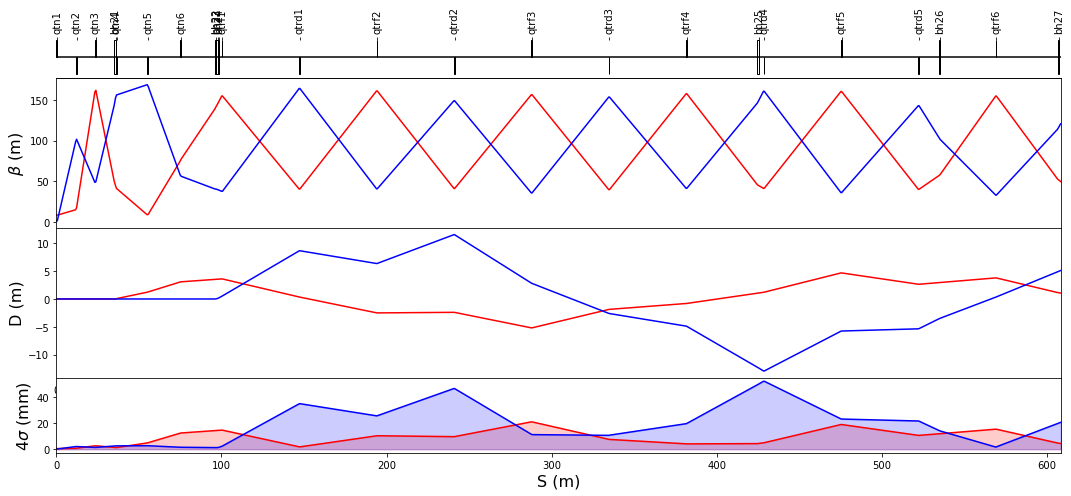

In [8]:
linac_seq = f'''
dlinac = 35 + 4*{BH2_L} + 60;

linac_seq: sequence, l=dlinac, refer=entry;
    LINAC_HANDOVER: marker, at = 0;
    QTN1: qtn, at = 0, k1 := kQTN1;
    QTN2: qtn, at = 35/3, k1 := kQTN2;
    QTN3: qtn, at = 2*35/3, k1 := kQTN3;
    BH21: bh2, at = 35, angle := 0.0609;
    QTN4: qtn, at = 35 + {BH2_L}, k1 := kQTN4;
    QTN5: qtn, at = 55, k1 := kqtn5;
    QTN6: qtn, at = 75, k1 := kqtn6;
    BH22: bh2, at = 95+{BH2_L}, angle =0.162/3, tilt = pi/2 ;
    BH23: bh2, at = 95+2*{BH2_L}, angle =0.162/3, tilt = pi/2;
    BH24: bh2, at = 95+3*{BH2_L}, angle =0.162/3, tilt = pi/2;
    FODO_HANDOVER: marker, at=dlinac;
endsequence;
'''

fodo_seq = f'''
dfodo = 326 + {BH2_L} + 109 + {BH2_L} + 71 + {BH2_L} + 1;
dend = {ideal_s}; ! Distance from last fodo quad to end of line;
dquad = {l_fodo};
fodo_seq: sequence, l=dfodo, refer=entry;
    START_FODO: marker, at=0;
    QTRf1: QTRf, at=dfodo-10*dquad-dend;
    QTRd1: QTRd, at=dfodo-9*dquad-dend;
    QTRf2: QTRf, at=dfodo-8*dquad-dend;
    QTRd2: QTRd, at=dfodo-7*dquad-dend;
    QTRf3: QTRf, at=dfodo-6*dquad-dend;
    QTRd3: QTRd, at=dfodo-5*dquad-dend;
    QTRf4: QTRf, at=dfodo-4*dquad-dend;
    BH25: BH2, at=326, angle = -0.0096, tilt = pi/2;
    QTRd4: QTRd, at=dfodo-3*dquad-dend;
    QTRf5: QTRf, at=dfodo-2*dquad-dend;
    QTRd5: QTRd, at=dfodo-1*dquad-dend;
    BH26: BH2, at=326 + {BH2_L} + 109, angle=-0.0405, tilt = pi/2;
    QTRf6: QTRf, at=dfodo-dend;
    BH27: BH2, at=dfodo-{BH2_L}-1, angle=0.0343;
    END_FODO: marker, at=dfodo;
endsequence;


linac_ti2: sequence, refer=entry, l= dlinac + dfodo;
  linac_seq, at=0;
  fodo_seq, at=dlinac;
  endsequence;
'''

madx.input(define_eles)
madx.input(linac_seq)
madx.input(fodo_seq)

#Finding beta values for periodic structure
def betmax_min(L, mu):
    betmax = 2 * L * (1+np.sin(mu/2))/np.sin(mu)
    betmin = 2 * L * (1-np.sin(mu/2))/np.sin(mu)
    return betmax, betmin
betmax, betmin = betmax_min(l_fodo, 0.895)
print(betmax, betmin)

madx.use('linac_ti2')
with madx.batch():
    madx.command.match(sequence='linac_ti2', **{'BETX':9,'BETY':1.5})
    madx.input('CONSTRAINT, weight=100, range=#s/#e, betx<150;')
    madx.input('CONSTRAINT, weight=100, range=#s/#e, bety<150;')
    madx.input(f'CONSTRAINT, weight=100, range=qtrf2, betx={betmax}, bety={betmin};')
    madx.input(f'CONSTRAINT, weight=100, range=qtrf3, betx={betmax}, bety={betmin};')

    k_vals = ['kqtn1','kqtn2','kqtn3','kqtn4','kqtn5','kqtn6']
    for i, kQTN in enumerate(k_vals):
        madx.command.vary(step=1e-4, name=kQTN,lower=-QTN_k, upper=QTN_k)
        
    madx.command.vary(step=1e-4, name='kQTRf',lower=-QTR_k, upper=QTR_k)
    madx.command.vary(step=1e-4, name='kQTRd',lower=-QTR_k, upper=QTR_k)

    madx.simplex(calls=30000, tolerance=1e-10)
    madx.endmatch()

madx.use('linac_ti2')
twiss_linac = madx.twiss(BETX=9,BETY=1.5).dframe()

twiss_fodo = {'betx':twiss_linac.iloc[-1].bety,
             'alfx':twiss_linac.iloc[-1].alfx, 'bety':twiss_linac.iloc[-1].bety,
             'alfy':twiss_linac.iloc[-1].alfy, 'dx':twiss_linac.iloc[-1].dx,
             'dpx':twiss_linac.iloc[-1].dpx, 'dy':twiss_linac.iloc[-1].dy, 
             'dpy':twiss_linac.iloc[-1].dpy}


fig = plt.figure(figsize=(15,7))
plot_this_twiss(fig, twiss_linac)

## Defining which quadrupoles are to be matched in TT61 

In [9]:
const = {}
for ele in madx.sequence['handover_to_sps'].elements:
    try:
        if ele.k1 != 0:
            const[ele.name] = ele.k1
    except:
        continue
print(const)

{'mqid.20300': -0.01625920587, 'mqif.20200': 0.015470817618, 'mqid.20100': -0.022907556209, 'qtlf.610600': 0.009603004237, 'qtld.610500': -0.012519269693, 'qtlf.610400': 0.012495503504, 'qtld.610300': -0.009944743836, 'qtlf.610200': 0.014437230933, 'qtld.610100': -0.01174858369}


## Matching Sequence - Values to alter

In [10]:
#Attaching sequences together
madx.input('''
linac_tt60: sequence, refer=entry, l= dlinac + dfodo + handover_length;
linac_ti2, at=0;
handover_to_sps, at = dlinac + dfodo;
endsequence;
''')

madx.input('''
eSPS_Inject: sequence, refer=entry, l= dlinac + dfodo + handover_length + sps_length;
linac_tt60, at = 0;
sps_rev, at = dlinac + dfodo + handover_length;
endsequence;
''')

madx.input('''
Beam, particle=ELECTRON,pc=3.5,exn=3.5e-6,eyn=3.5E-6, sequence = eSPS_Inject;
''')

madx.use('eSPS_Inject')

#Begin matching
with madx.batch():
    madx.command.match(sequence='eSPS_Inject', **{'BETX':9,'BETY':1.5})

    madx.input('CONSTRAINT, weight=100, range=#s/qtrf6, betx<150;')
    madx.input('CONSTRAINT, weight=100, range=#s/qtrf6, bety<150;')
    
    madx.input(f'CONSTRAINT, weight=100, range=qtrf2, betx={betmax}, bety={betmin};')
    madx.input(f'CONSTRAINT, weight=100, range=qtrf3, betx={betmax}, bety={betmin};')
    
    madx.input('CONSTRAINT, weight=10, range=qtrf6/mdav.610013, betx<200;')
    madx.input('CONSTRAINT, weight=10, range=qtrf6/mdav.610013, bety<200;')
    
    madx.input('CONSTRAINT, weight=100, range=mdav.610013/QF.61410, betx<100;')
    madx.input('CONSTRAINT, weight=100, range=mdav.610013/QF.61410, bety<100;')

    k_vals = ['kqtn1','kqtn2','kqtn3','kqtn4','kqtn5','kqtn6']
    for i, kQTN in enumerate(k_vals):
        madx.command.vary(step=1e-4, name=kQTN,lower=-QTN_k, upper=QTN_k)
        
    madx.command.vary(step=1e-4, name='kQTRf',lower=-QTR_k, upper=QTR_k)
    madx.command.vary(step=1e-4, name='kQTRd',lower=-QTR_k, upper=QTR_k)

    for quad in const:
        if const[quad] > 0:
            madx.command.vary(step=1e-5,name=f'{quad}->K1', lower=-1.1*const[quad], upper=1.1*const[quad])
        if const[quad] < 0:
            madx.command.vary(step=1e-5, name=f'{quad}->K1', lower=1.1*const[quad], upper=-1.1*const[quad])
    
    madx.simplex(calls=1000, tolerance=1e-5)
    madx.endmatch()

START MATCHING

number of sequences: 1
sequence name: esps_inject
entry name: betx
number of entries: 1
entry value: 9.000000
entry name: bety
number of entries: 1
entry value: 1.500000
number of variables:    17
user given constraints: 1
total constraints:      522

START SIMPLEX:

call:      94   Penalty function =   0.11796769E+09
call:     100   Penalty function =   0.11716020E+09
call:     102   Penalty function =   0.11387944E+09
call:     107   Penalty function =   0.11224801E+09
call:     110   Penalty function =   0.11082042E+09
call:     114   Penalty function =   0.10816961E+09
call:     123   Penalty function =   0.10585317E+09
call:     125   Penalty function =   0.10556914E+09
call:     127   Penalty function =   0.10546958E+09
call:     161   Penalty function =   0.10541471E+09
call:     167   Penalty function =   0.10505819E+09
call:     170   Penalty function =   0.10494965E+09
call:     174   Penalty function =   0.10454482E+09
call:     178   Penalty function =   0.1

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:    -4.495653E-06  1.491890E-07  2.183434E-06 -3.996357E-08 -1.149001E-09  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
        7826.59178                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       28.76616764                  0        247.5109059        10.11281965 

             dxrms             xcomax             xcorms                 q2 
       3.690052075    1.003514786e-05    5.230752453e-06        28.46017409 

               dq2            betymax              dymax              dyrms 
                 0        219.5635324        13.29213275        5.153367908 

            ycomax             ycorms             deltap            synch_1 


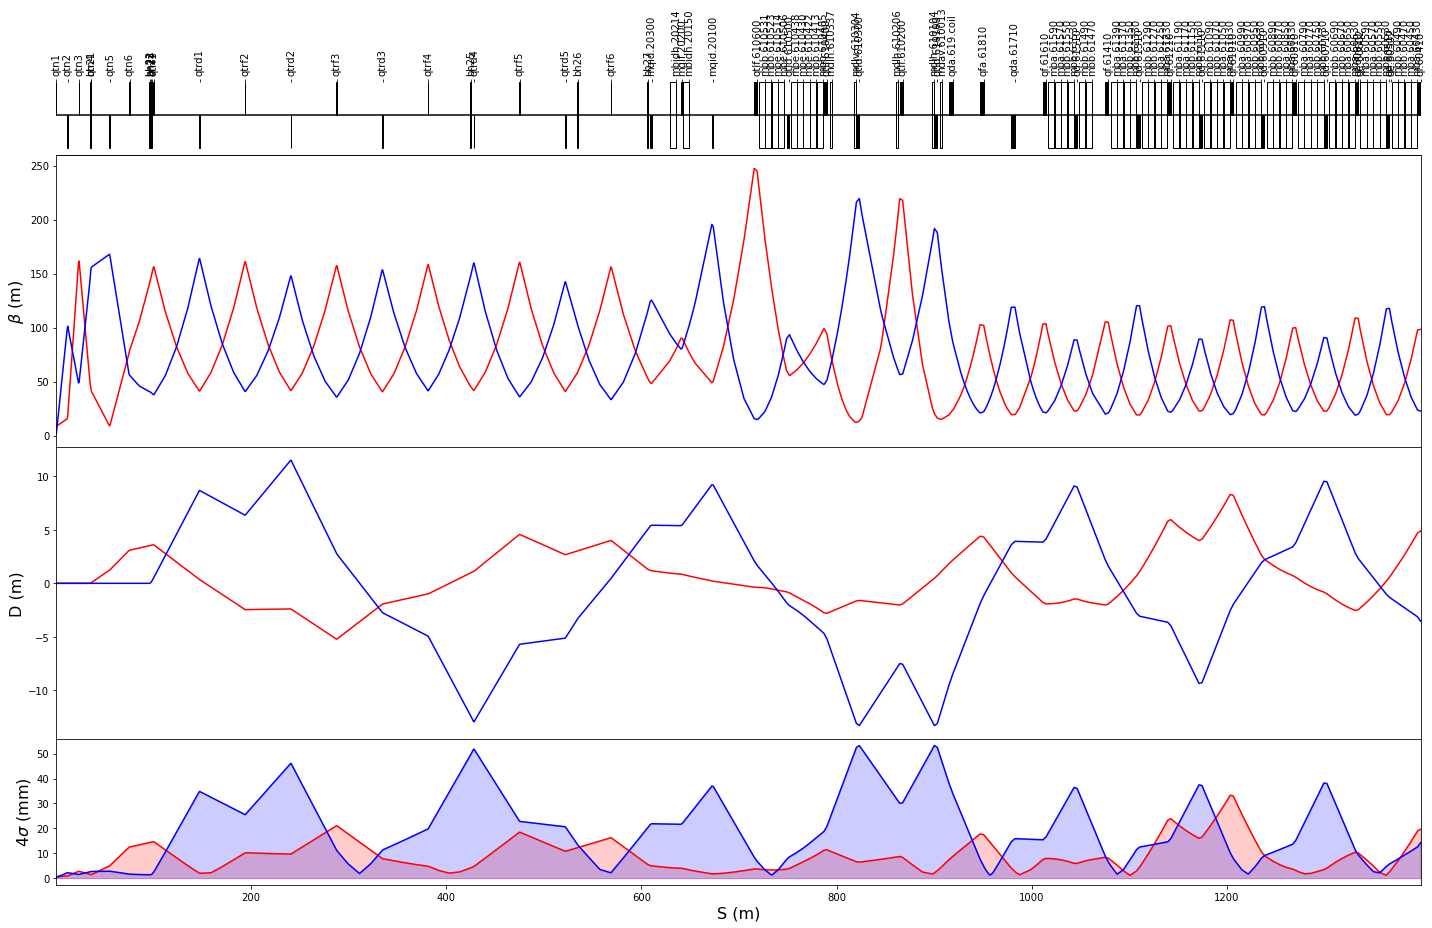

In [11]:
#Plot figure until SPS qf.60410 magnet
madx.use('eSPS_Inject')
madx.input('select, flag=interpolate, step=10;')
twiss_sps_rev = madx.twiss(BETX=9,BETY=1.5).dframe()

Twiss_vals = twiss_sps_rev.loc['qtn1':'qf.60410']
fig = plt.figure(figsize=(20,13))
plot_this_twiss(fig, Twiss_vals) 

### Beam Size

In [12]:
#Defining properties used in beam size
pc = 3.5 # GeV/c
m_e = 0.511e-3 # GeV
betagamma = pc/m_e
emit_n = 20e-6 # m
emit = emit_n / betagamma
dpp = 1e-3

#1 sigma beamsize
size_x = np.sqrt(emit * Twiss_vals.betx + Twiss_vals.dx**2 * dpp**2 ) * 1E3 #Equation for one sigma
size_y = np.sqrt(emit * Twiss_vals.bety + Twiss_vals.dy**2 * dpp**2 ) * 1E3 #Equation for one sigma

## Calculating Aperture Size

In [13]:
dlinac = madx.globals.dlinac
dfodo = madx.globals.dfodo
dhandover = madx.globals.handover_length
dsps = madx.globals.sps_length

S = []
Names = []

#Probably should have made this a function to be more efficient
for ele in madx.sequence["linac_seq"].elements:
    try:
        Names.append(ele.name)
        S.append([ele.at, list(ele.aperture)[0], list(ele.aperture)[1]])
        S.append([ele.at+ele.l, list(ele.aperture)[0], list(ele.aperture)[1]])
    except:
        Names.append(ele.name)
        S.append([ele.at, list(ele.aperture)[0], list(ele.aperture)[0]])
        S.append([ele.at+ele.l, list(ele.aperture)[0], list(ele.aperture)[0]])

for ele in madx.sequence["fodo_seq"].elements:
    try:
        Names.append(ele.name)
        S.append([ele.at+dlinac, list(ele.aperture)[0], list(ele.aperture)[1]])
        S.append([ele.at+dlinac+ele.l, list(ele.aperture)[0], list(ele.aperture)[1]])
    except:
        Names.append(ele.name)
        S.append([ele.at+dlinac, list(ele.aperture)[0], list(ele.aperture)[0]])
        S.append([ele.at+dlinac+ele.l, list(ele.aperture)[0], list(ele.aperture)[0]])
        
for ele in madx.sequence["handover_to_sps"].elements:
    try:
        Names.append(ele.name)
        S.append([ele.at+dlinac+dfodo, list(ele.aperture)[0], list(ele.aperture)[1]])
        S.append([ele.at+dlinac+dfodo+ele.l, list(ele.aperture)[0], list(ele.aperture)[1]])
    except:
        Names.append(ele.name)
        S.append([ele.at+dlinac+dfodo, list(ele.aperture)[0], list(ele.aperture)[0]])
        S.append([ele.at+dlinac+dfodo+ele.l, list(ele.aperture)[0], list(ele.aperture)[0]])

for ele in madx.sequence["sps_rev"].elements:
    try:
        Names.append(ele.name)
        S.append([ele.at+dlinac+dfodo+dhandover, list(ele.aperture)[0], list(ele.aperture)[1]])
        S.append([ele.at+dlinac+dfodo+dhandover+ele.l, list(ele.aperture)[0], list(ele.aperture)[1]])
    except:
        Names.append(ele.name)
        S.append([ele.at+dlinac+dfodo+dhandover, list(ele.aperture)[0], list(ele.aperture)[0]])
        S.append([ele.at+dlinac+dfodo+dhandover+ele.l, list(ele.aperture)[0], list(ele.aperture)[0]])

S = np.array(S)
s = []
for i in range(len(S)):
    if S[i,1]==0 or S[i,2]==0 or S[i,1]==1 or S[i,2]==1:
        pass
    else:
        s.append([S[i,0], S[i,1]*1E3, S[i,2]*1E3])
s = np.array(s)


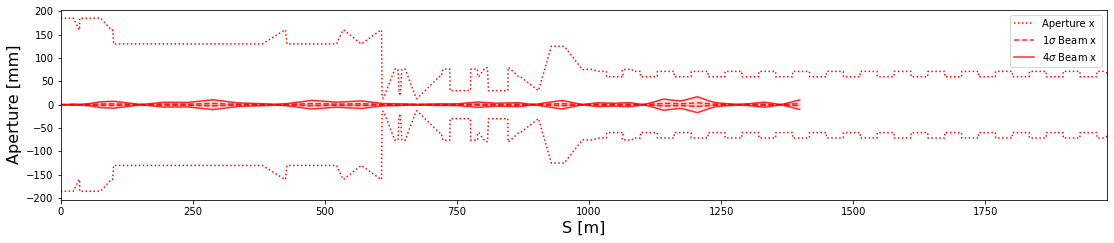

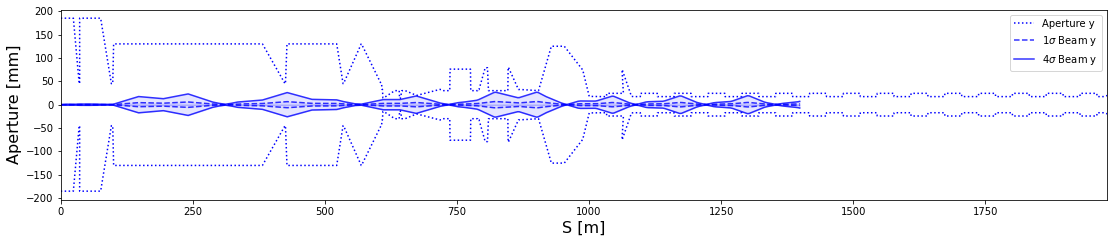

In [14]:
#Plotting the aperture of the beamline and the beam within it
fig = plt.figure(figsize=(15*1.25,7/2))

plt.plot(s[:,0], s[:,1], color = 'red', alpha = 1, linestyle=':', label='Aperture x')
plt.plot(Twiss_vals.s, size_x/2, color = 'red', alpha = 0.85, linestyle='--',label='1$\sigma$ Beam x')
plt.plot(Twiss_vals.s, 4*size_x/2, color = 'red', alpha = 0.85, label='4$\sigma$ Beam x')

plt.plot(s[:,0], -s[:,1], color = 'red', alpha = 1, linestyle=':')
plt.plot(Twiss_vals.s, -size_x/2, color = 'red', linestyle='--', alpha = 0.85)
plt.plot(Twiss_vals.s, -4*size_x/2, color = 'red', alpha = 0.8)

plt.fill_between(Twiss_vals.s,size_x/2, color='red', alpha=0.05)
plt.fill_between(Twiss_vals.s,-size_x/2, color='red', alpha=0.05)

plt.fill_between(Twiss_vals.s,4*size_x/2, color='red', alpha=0.1)
plt.fill_between(Twiss_vals.s,-4*size_x/2, color='red', alpha=0.1)

plt.xlabel("S [m]")
plt.ylabel("Aperture [mm]")
plt.legend()
plt.xlim(0,1980)
plt.show()

fig = plt.figure(figsize=(15*1.25,7/2))

plt.plot(s[:,0], s[:,2], color = 'blue', alpha = 1, linestyle=':', label='Aperture y')
plt.plot(Twiss_vals.s, size_y/2, color = 'blue', alpha = 0.8, linestyle='--',label='1$\sigma$ Beam y')
plt.plot(Twiss_vals.s, 4*size_y/2, color = 'blue', alpha = 0.8, label='4$\sigma$ Beam y')

plt.plot(s[:,0], -s[:,2], color = 'blue', alpha = 1, linestyle=':')
plt.plot(Twiss_vals.s, -size_y/2, color = 'blue', linestyle='--', alpha = 0.8)
plt.plot(Twiss_vals.s, -4*size_y/2, color = 'blue', alpha = 0.8)

plt.fill_between(Twiss_vals.s,size_y/2, color='blue', alpha=0.05)
plt.fill_between(Twiss_vals.s,-size_y/2, color='blue', alpha=0.05)

plt.fill_between(Twiss_vals.s,4*size_y/2, color='blue', alpha=0.1)
plt.fill_between(Twiss_vals.s,-4*size_y/2, color='blue', alpha=0.1)

plt.xlabel("S [m]")
plt.ylabel("Aperture [mm]")
plt.legend()
plt.xlim(0,1980)
plt.show()

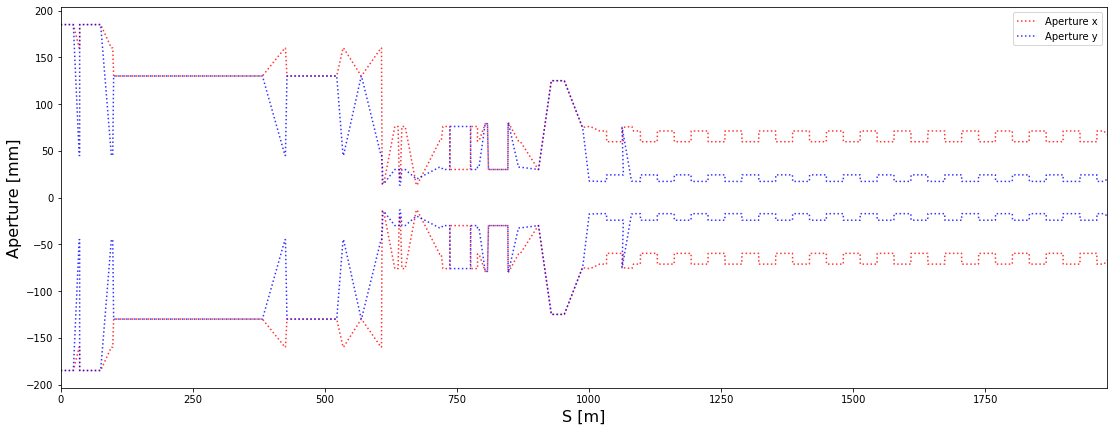

In [15]:
#Plotting just the aperture
fig = plt.figure(figsize=(15*1.25,7))

plt.plot(s[:,0], s[:,1], color = 'red', alpha = 0.8, linestyle=':', label='Aperture x')
plt.plot(s[:,0], -s[:,1], color = 'red', alpha = 0.8, linestyle=':')
plt.plot(s[:,0], s[:,2], color = 'blue', alpha = 0.8, linestyle=':', label='Aperture y')
plt.plot(s[:,0], -s[:,2], color = 'blue', alpha = 0.8, linestyle=':')

plt.xlabel("S [m]")
plt.ylabel("Aperture [mm]")
plt.legend()
plt.xlim(0,1980)
plt.show()

## Geometrical Acceptance Plot

(500.0, 700.0)

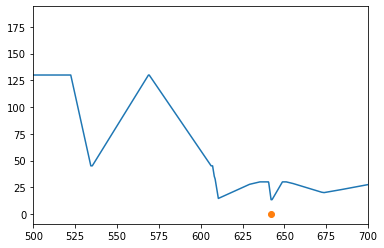

In [16]:
# Interpolating to ensure that both aperture and beam size are using the same s values
from scipy import interpolate

S = s[:,0]
x_aper = s[:,1]
y_aper = s[:,2]
Sx = interpolate.interp1d(S, x_aper)
Sy = interpolate.interp1d(S, y_aper)

XAper = Sx(Twiss_vals.s) 
YAper = Sy(Twiss_vals.s) 

nx = XAper/size_x
ny = YAper/size_y

plt.plot(Twiss_vals.s, YAper)
plt.plot(642.026409, 0.019, marker='o')
plt.xlim(500, 700)

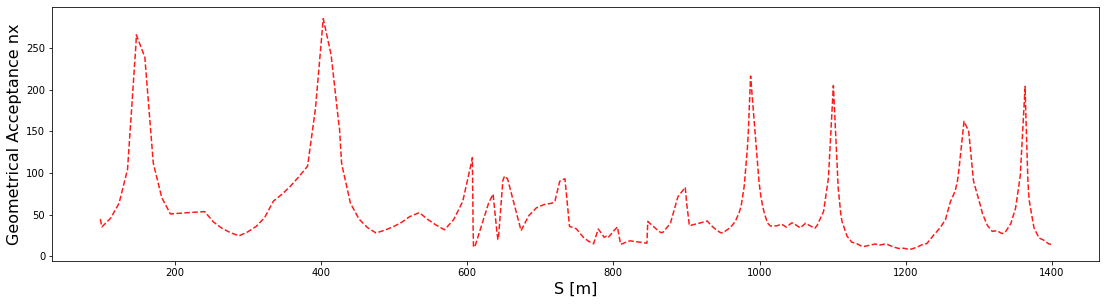

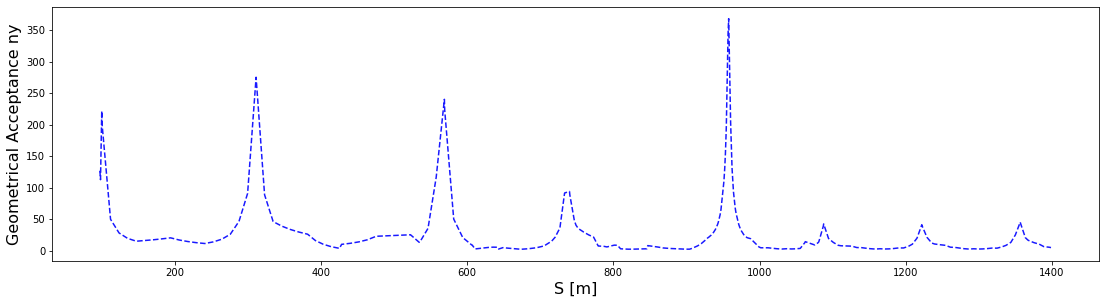

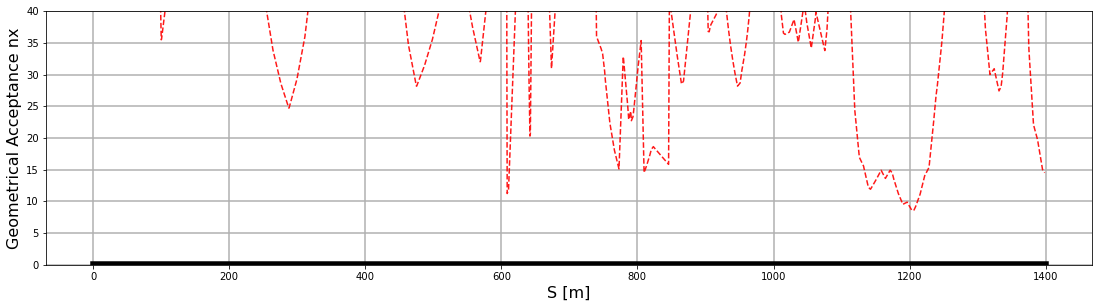

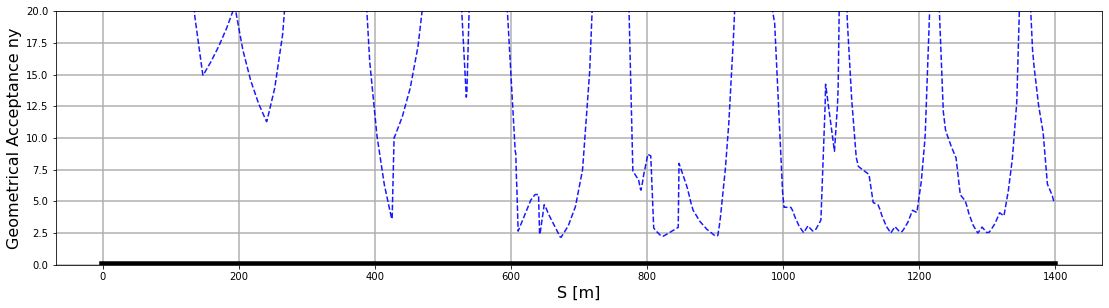

In [17]:
fig = plt.figure(figsize=(15*1.25,7/1.5))
plt.plot(Twiss_vals.s[15:], nx[15:], color = 'red', alpha = 0.9, linestyle='--')
plt.xlabel("S [m]")
plt.ylabel("Geometrical Acceptance nx")
plt.show() 

fig = plt.figure(figsize=(15*1.25,7/1.5))
plt.plot(Twiss_vals.s[15:], ny[15:], color = 'blue', alpha = 0.9, linestyle='--')
plt.xlabel("S [m]")
plt.ylabel("Geometrical Acceptance ny")
plt.show() 


fig = plt.figure(figsize=(15*1.25,7/1.5))
plt.plot(Twiss_vals.s, nx, color = 'red', alpha = 0.9, linestyle='--')
plt.plot(Twiss_vals.s, np.zeros(len(nx)), color='k', linewidth=7.5)
plt.xlabel("S [m]")
plt.ylabel("Geometrical Acceptance nx")
plt.ylim(0, 40)
plt.grid(linewidth=1.5)
plt.show() 

fig = plt.figure(figsize=(15*1.25,7/1.5))
plt.plot(Twiss_vals.s, ny, color = 'blue', alpha = 0.9, linestyle='--')
plt.plot(Twiss_vals.s, np.zeros(len(ny)), color='k', linewidth=7.5)
plt.xlabel("S [m]")
plt.ylabel("Geometrical Acceptance ny")
plt.ylim(0, 20)
plt.grid(linewidth=1.5)
plt.show() 

### Gaussian cut-off of beam from beamsize and geometrical acceptance

/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


2.1685908749089866
8.556975203684072


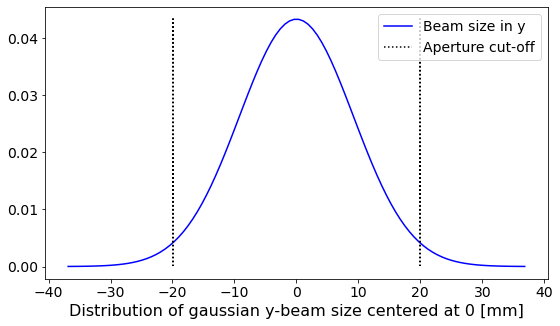

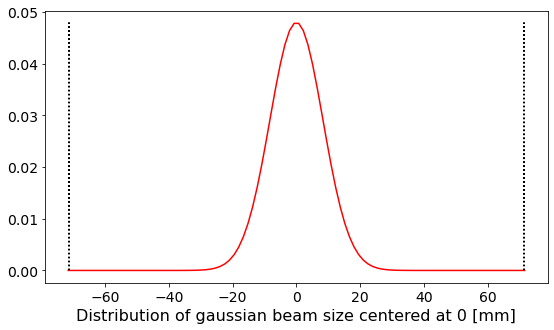

In [18]:
#Plotting gaussian distribution of beam
from matplotlib import pyplot as plt
import numpy as np
import math
plt.rcParams.update({'font.size': 14})

sigma_y = size_y[np.argmin(ny)]
apery_min = np.min(ny)
print(apery_min)

sigma_x = size_x[np.argmin(nx)]
aperx_min = np.min(nx)
print(aperx_min)

def gaussian(x, mu, sigma):
    return (2*np.pi*sigma**2)**(-0.5) * np.exp(-(x - mu)**2 / (2*sigma**2))

x = np.linspace(-4*sigma_y, 4*sigma_y, 100)

fig = plt.figure(figsize=(9,5))
plt.plot(x, gaussian(x, 0, sigma_y), color='b', label='Beam size in y')
plt.plot(-apery_min*sigma_y*np.ones(len(x)), gaussian(x, 0, sigma_y), color='k', linestyle=':', label='Aperture cut-off')
plt.plot(apery_min*sigma_y*np.ones(len(x)), gaussian(x, 0, sigma_y), color='k', linestyle=':')
plt.xlabel("Distribution of gaussian y-beam size centered at 0 [mm]")
plt.legend(loc=1)
plt.show()



x1 = np.linspace(-8.6*sigma_x, 8.6*sigma_x, 100)
fig = plt.figure(figsize=(9, 5))
plt.plot(x1, gaussian(x1, 0, sigma_x), color='r')
plt.plot(-aperx_min*sigma_x*np.ones(len(x1)), gaussian(x1, 0, sigma_x), color='k', linestyle=':')
plt.plot(aperx_min*sigma_x*np.ones(len(x1)), gaussian(x1, 0, sigma_x), color='k', linestyle=':')
plt.xlabel("Distribution of gaussian beam size centered at 0 [mm]")

plt.show()

In [19]:
from scipy import integrate

gaus_y = lambda y: gaussian(y, 0, sigma_y)
gaus_x = lambda x: gaussian(x, 0, sigma_x)

print(integrate.quad(gaus_y, -apery_min*sigma_y, apery_min*sigma_y)[0]*100)

print(integrate.quad(gaus_x, -aperx_min*sigma_x, aperx_min*sigma_x)[0]*100)

96.98862414294234
99.99999999999999


### Producing diagram used in the eSPS report

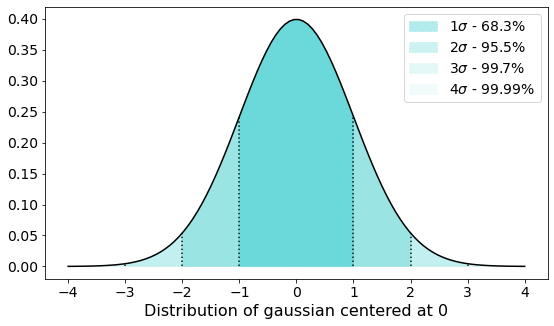

In [20]:
plt.rcParams.update({'font.size': 14})

sig = 1

def gaussian(x, mu, sigma):
    return (2*np.pi*sigma**2)**(-0.5) * np.exp(-(x - mu)**2 / (2*sigma**2))

x1 = np.linspace(-1*sig, 1*sig, 100)
x2 = np.linspace(-2*sig, 2*sig, 100)
x3 = np.linspace(-3*sig, 3*sig, 100)
x4 = np.linspace(-4*sig, 4*sig, 100)
x = np.linspace(-4*sig, 4*sig, 100)

fig = plt.figure(figsize=(9,5))
plt.plot(x, gaussian(x, 0, sig), color='k')

plt.fill_between(x1, gaussian(x1, 0, sig), color='c', alpha=0.3, linestyle=':', label='1$\sigma$ - 68.3%')
plt.fill_between(x2, gaussian(x2, 0, sig), color='c', alpha=0.2, linestyle=':', label='2$\sigma$ - 95.5%')
plt.fill_between(x3, gaussian(x3, 0, sig), color='c', alpha=0.1, linestyle=':', label='3$\sigma$ - 99.7%')
plt.fill_between(x4, gaussian(x4, 0, sig), color='c', alpha=0.05, linestyle=':', label='4$\sigma$ - 99.99%')

plt.plot( sig*np.ones(len(x)), np.linspace(0, gaussian(sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)
plt.plot(-sig*np.ones(len(x)), np.linspace(0, gaussian(sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)

plt.plot( 2*sig*np.ones(len(x)), np.linspace(0, gaussian(2*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)
plt.plot(-2*sig*np.ones(len(x)), np.linspace(0, gaussian(2*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)

plt.plot( 3*sig*np.ones(len(x)), np.linspace(0, gaussian(3*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)
plt.plot(-3*sig*np.ones(len(x)), np.linspace(0, gaussian(3*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)

plt.plot( 4*sig*np.ones(len(x)), np.linspace(0, gaussian(4*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)
plt.plot(-4*sig*np.ones(len(x)), np.linspace(0, gaussian(4*sig, 0, sig), 100), color='k', linestyle=':', alpha=0.9)

plt.fill_between(x, gaussian(x, 0, sig), color='c', alpha=0.1, linestyle=':')
plt.xlabel("Distribution of gaussian centered at 0")
plt.legend(loc=1)
plt.show()

plt.show()

In [33]:
import pandas as pd

#First need to clean up the data
#Reads the textfile produced from PTCtrack. Formats by removing whitespace. Removes the column labelled *, skips the header and the first two rows.
data = pd.read_csv('track_eSPS.txtone', delim_whitespace=True, names=['Number', 'Turn', 'X', 'PX', 'Y', 'PY', 'T', 'PT', 'S', 'E'], header = 6, skiprows=2)

#Removes the line between each turn called "segment". Ensures all values are numbers not strings
data = data[data.Number != '#segment'].astype(float)
data.head()

,Number,Turn,X,PX,Y,PY,T,PT,S,E
0,1.0,0.0,0.007673,-0.000193,0.000645,-0.000038,0.0,0.0,0.0,450.000978
1,2.0,0.0,0.003698,-0.000084,-0.000010,-0.000001,0.0,0.0,0.0,450.000978
2,3.0,0.0,0.001728,-0.000057,-0.000943,0.000008,0.0,0.0,0.0,450.000978
3,4.0,0.0,0.003649,-0.000082,0.000712,-0.000018,0.0,0.0,0.0,450.000978
4,5.0,0.0,-0.002899,0.000072,-0.000055,0.000008,0.0,0.0,0.0,450.000978


In [23]:
madx.use('eSPS_Inject')
#Setting up PTC environment
madx.input('''
ptc_create_universe;
ptc_create_layout,model=2,method=2,nst=5;

PTC_ALIGN;''')

madx.input(f'ptc_start, x = 0.0001, px=0, y=0.0001, py=0, t=0;')
madx.input('ptc_observe, place=qtn6;')
madx.input('ptc_observe, place=qtrf6;')

#Complete the tracking and save all particles to one file called track_eSPS.txtone
madx.input('''ptc_track, turns=1,  element_by_element=True, file="track_eSPS.txt", ONETABLE=True;
ptc_track_end;
ptc_end;''')

Determined SECTOR NMUL MAX :  2
 MAD-X Beam Parameters
                  Energy : 0.350000E+01
          Kinetic Energy : 0.349949E+01
      Particle Rest Mass : 0.510999E-03
                Momentum : 0.350000E+01
 Setting MADx with 
     energy           3.5000000373028466     
     method                   2
     Num. of steps            5
     charge          -1.0000000000000000     
  Length of machine:    7826.5917799992621     
 The machine is a RING
 ------------------------------------ PTC Survey ------------------------------------
 Before start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 Before   end:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After  start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After    end:   -61.537166306319108       -105.19599884435881        905.49764935955056     
obs_points: 2 
obs_points: 3 
 ************ State Summary ****************
 

True

In [24]:
#Anaylsis and plotting files written by R. Taylor
from Beam_Functions import MakeTwissBeam, PlotTurn, GifTurn, PlotManyTurn

In [26]:
pc = 3.5 # GeV/c
m_e = 0.511e-3 # GeV
betagamma = pc/m_e
emit_n = 20e-6 # m
emit = emit_n / betagamma
dpp = 1e-3


def MakeTwissBeam():
    ''' This function produces one gaussian distributed particle for a given beam optics.
    It calculates the sigmas of the gaussian distributions in each dimension using epsilon, beta and gamma.
    It calculates the rotation of the beam in x or y as phi.
    The produced particle is rotated depending on phi.
    Input:
        Param : Of the madx twiss format
        e : emittance (ex, ey)
    Returns:
        One random value of x, xp, y, yp 
    '''
    
    betx, bety = Twiss_vals.betx['mqif.20200'], Twiss_vals.bety['mqif.20200']
    alfx, alfy = Twiss_vals.alfx['mqif.20200'], Twiss_vals.alfy['mqif.20200']
    gammax, gammay  = (1+alfx**2)/betx, (1+alfy**2)/bety
    
    Dx, Dy = Twiss_vals.dx['mqif.20200'], Twiss_vals.dy['mqif.20200']
    Dxp, Dyp = Twiss_vals.dpx['mqif.20200'], Twiss_vals.dpy['mqif.20200']
    
    ex, ey = emit, emit
    
    x0, y0 = Twiss_vals.x['mqif.20200'], Twiss_vals.y['mqif.20200']
    xp0, yp0 = Twiss_vals.px['mqif.20200'], Twiss_vals.py['mqif.20200']
    
    
    #Sigma for each dimension
    x_rms = np.sqrt(ex * betx + Dx**2 * dpp**2)
    y_rms = np.sqrt(ey * bety + Dy**2 * dpp**2)
    xp_rms = np.sqrt(ex * gammax)
    yp_rms = np.sqrt(ey * gammay)

    #Creating a Gaussian spread according to sigma and position
    X = np.random.normal(x0, x_rms)       
    Xp = np.random.normal(xp0, xp_rms)
    Y = np.random.normal(y0, y_rms)
    Yp = np.random.normal(yp0, yp_rms)
    
    #Angle dependant on alpha, beta and gamma 
    phi_x = 1/2 * np.arctan(2*alfx / (gammax - betx)) #Find a source for this
    phi_y = 1/2 * np.arctan(2*alfy / (gammay - bety))

    Cx = np.cos(phi_x)             #Angle of the beam to rotate
    Cy = np.cos(phi_y)
    Sx = np.sin(phi_x)
    Sy = np.sin(phi_y)

    V = np.array((X, Xp, Y, Yp))
    M = np.array(((Cx, Sx, 0, 0), (-Sx, Cx, 0, 0), (0, 0, Cy, -Sy), (0, 0, Sy, Cy)))
    P = np.matmul(V, M)
    return(P[0], P[1], P[2], P[3])

print(MakeTwissBeam())

(-0.0009402926908948333, 1.23819379934323e-05, -0.005412484393047105, 7.869117887414016e-05)


In [27]:
X, Y = [], []
XP, YP = [], []
for i in range(10000):
    x, xp, y, yp = MakeTwissBeam()
    X.append(x)
    XP.append(xp)
    Y.append(y)
    YP.append(yp)

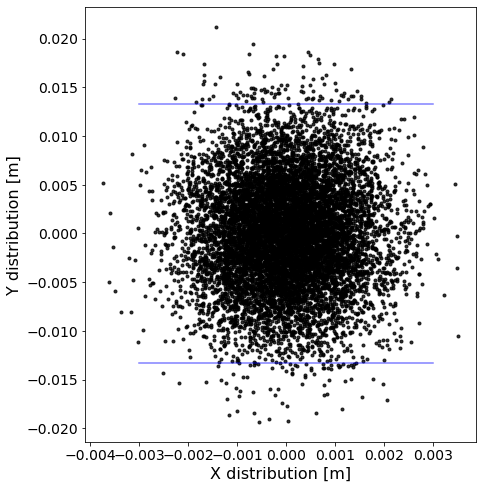

In [28]:
#Making and plotting the beam at the point of shortest aperture
plt.figure(figsize=(7, 8))

plt.xlabel('X distribution [m]')
plt.ylabel('Y distribution [m]')
plt.plot(X, Y, marker='.', linestyle='', color='k', alpha=0.8)
plt.plot(np.linspace(-3E-3, 3E-3, 10), 0.01333*np.ones(10), color='b', alpha=0.5)
plt.plot(np.linspace(-3E-3, 3E-3, 10), -0.01333*np.ones(10), color='b', alpha=0.5)

In [29]:
pc = 3.5 # GeV/c
m_e = 0.511e-3 # GeV
betagamma = pc/m_e
emit_n = 20e-6 # m
emit = emit_n / betagamma
dpp = 1e-3


def MakeTwissBeam():
    ''' This function produces one gaussian distributed particle for a given beam optics.
    It calculates the sigmas of the gaussian distributions in each dimension using epsilon, beta and gamma.
    It calculates the rotation of the beam in x or y as phi.
    The produced particle is rotated depending on phi.
    Input:
        Param : Of the madx twiss format
        e : emittance (ex, ey)
    Returns:
        One random value of x, xp, y, yp 
    '''
    element = 'qfa.61810'
    betx, bety = Twiss_vals.betx[element], Twiss_vals.bety[element]
    alfx, alfy = Twiss_vals.alfx[element], Twiss_vals.alfy[element]
    gammax, gammay  = (1+alfx**2)/betx, (1+alfy**2)/bety
    
    Dx, Dy = Twiss_vals.dx[element], Twiss_vals.dy[element]
    Dxp, Dyp = Twiss_vals.dpx[element], Twiss_vals.dpy[element]
    
    ex, ey = emit, emit
    
    x0, y0 = Twiss_vals.x[element], Twiss_vals.y[element]
    xp0, yp0 = Twiss_vals.px[element], Twiss_vals.py[element]
    
    
    #Sigma for each dimension
    x_rms = np.sqrt(ex * betx + Dx**2 * dpp**2)
    y_rms = np.sqrt(ey * bety + Dy**2 * dpp**2)
    xp_rms = np.sqrt(ex * gammax)
    yp_rms = np.sqrt(ey * gammay)

    #Creating a Gaussian spread according to sigma and position
    X = np.random.normal(x0, x_rms)       
    Xp = np.random.normal(xp0, xp_rms)
    Y = np.random.normal(y0, y_rms)
    Yp = np.random.normal(yp0, yp_rms)
    
    #Angle dependant on alpha, beta and gamma 
    phi_x = 1/2 * np.arctan(2*alfx / (gammax - betx)) #Find a source for this
    phi_y = 1/2 * np.arctan(2*alfy / (gammay - bety))

    Cx = np.cos(phi_x)             #Angle of the beam to rotate
    Cy = np.cos(phi_y)
    Sx = np.sin(phi_x)
    Sy = np.sin(phi_y)

    V = np.array((X, Xp, Y, Yp))
    M = np.array(((Cx, Sx, 0, 0), (-Sx, Cx, 0, 0), (0, 0, Cy, -Sy), (0, 0, Sy, Cy)))
    P = np.matmul(V, M)
    return(P[0], P[1], P[2], P[3])

print(MakeTwissBeam())

(0.0016741727300066053, -3.436141855835618e-05, -0.0010003963519383697, 2.8063435435530174e-06)


In [30]:
madx.use('sps_rev')
#Setting up PTC environment
madx.input('''
ptc_create_universe;
ptc_create_layout,model=2,method=2,nst=5;

PTC_ALIGN;''')

for i in range(1000):
    X, Xp, Y, Yp = MakeTwissBeam()
    madx.input(f'ptc_start, x = {X}, px= {Xp}, y={Y}, py={Yp}, t=0;')

#Complete the tracking and save all particles to one file called track_eSPS.txtone
madx.input('''ptc_track, turns=10, file="track_eSPS.txt", ONETABLE=True;
ptc_track_end;
ptc_end;''')

Determined SECTOR NMUL MAX :  2
 MAD-X Beam Parameters
                  Energy : 0.450001E+03
          Kinetic Energy : 0.449063E+03
      Particle Rest Mass : 0.938272E+00
                Momentum : 0.450000E+03
 Setting MADx with 
     energy           450.00097817061624     
     method                   2
     Num. of steps            5
     charge           1.0000000000000000     
  Length of machine:    6911.5037999996539     
 The machine is a RING
 ------------------------------------ PTC Survey ------------------------------------
 Before start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 Before   end:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After  start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After    end:   -2.1708084092732177E-005   0.0000000000000000       -3.4322390776497791E-005
 ************ State Summary ****************
 MADTHICK=>KIND =   37  MATRIX-

True

In [34]:
import pandas as pd

#First need to clean up the data
#Reads the textfile produced from PTCtrack. Formats by removing whitespace. Removes the column labelled *, skips the header and the first two rows.
data = pd.read_csv('track_eSPS.txtone', delim_whitespace=True, names=['Number', 'Turn', 'X', 'PX', 'Y', 'PY', 'T', 'PT', 'S', 'E'], header = 6, skiprows=2)

#Removes the line between each turn called "segment". Ensures all values are numbers not strings
data = data[data.Number != '#segment'].astype(float)
data.head()

,Number,Turn,X,PX,Y,PY,T,PT,S,E
0,1.0,0.0,0.007673,-0.000193,0.000645,-0.000038,0.0,0.0,0.0,450.000978
1,2.0,0.0,0.003698,-0.000084,-0.000010,-0.000001,0.0,0.0,0.0,450.000978
2,3.0,0.0,0.001728,-0.000057,-0.000943,0.000008,0.0,0.0,0.0,450.000978
3,4.0,0.0,0.003649,-0.000082,0.000712,-0.000018,0.0,0.0,0.0,450.000978
4,5.0,0.0,-0.002899,0.000072,-0.000055,0.000008,0.0,0.0,0.0,450.000978


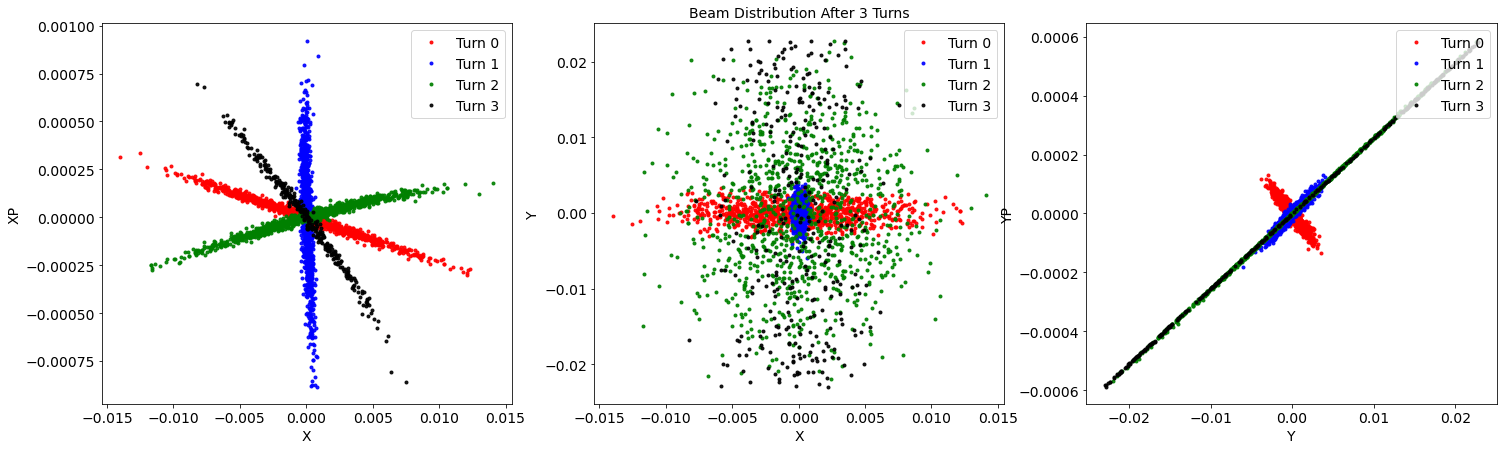

In [32]:
PlotManyTurn(data, [0,1,2,3])